## Configuration for Colab

In [ ]:
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
    
# Start virtual display
dis = Display(visible=0, size=(600, 400))
dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 0s (1,006 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 159447 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ff

## 01. A2C

### Actor-Critic

*Actor critic* method is one of the popular *policy optimization* algorithms. This approach maximizes the expected return by pushing up the probabilities of actions that receive higher returns. Let $\pi_\theta$ denote a policy with parameters $\theta$. The policy gradient of performance $\mathcal{J}(\pi_\theta)$ is

$$ \nabla_\theta \mathcal{J}(\pi_\theta) = \underset{\tau\sim\pi_\theta}{\mathbb{E}}\left[ \sum^T_{t=0} \nabla_\theta \log \pi_\theta(a_t|s_t)A^{\pi_\theta}(s_t, a_t) \right],$$

where $\tau$ is a trajectory and $A^{\pi_\theta}$ is the advantage function for reducing variance of values. The *policy gradient algorithm* updates the parameters by adding this gradient.

$$\theta_{k+1} = \theta_k + \alpha \nabla_\theta \mathcal{J}(\pi_{\theta_k}),$$

where $\alpha$ is a learning rate. The agent is trained in an on-policy way because the parameters are updated by the current policy. We call the policy *Actor* which predicts probabilities of actions in each state, and call the value function *Critic* that predicts values of all state-action pairs. 


### Advantage Function

The advantage function effectively reduces the variance of values and is defined as follows.

$$ A(s,a) = Q(s,a) - V(s) $$

From this formula, we can replace Q with $r+\gamma V(s')$ and redefine Advantage function without using Action-Value function.

$$ A(s,a) = r + \gamma V(s') - V(s) $$


### Maximization Entropy

Entropy is a measure of unpredictability or a measure of randomness. If we have actions with almost equal probabilities, the entropy over the actions will be the largest because it's completely unpredictable which action will be chosen. In view of the fact, we can encourage exploration by adding entropy maximization term to the loss function. The entropy $H$ with respect to the probability $p$ over actions is

$$ H(P) = - \sum_a p(a) \log p(a) $$


## import module

In [ ]:
import random
from typing import List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

## Set random seed

In [ ]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Network
When implementing A2C, we will use two separated networks for actor and critic respectively. 

The actor network consists of one fully connected hidden layer with ReLU branched out two fully connected output layers for mean and standard deviation of Normal distribution. [Pendulum-v1](https://www.gymlibrary.dev/environments/classic_control/pendulum/#pendulum) has only one action(torque) which is range from -2 to 2. In order to fit the range, the actor outputs the mean value that is multiplied by 2 after tanh. 

On the other hand, the critic network has two fully connected layers as a hidden layer (ReLU) and an output layer. One thing to note is that we initialize the last layers' weights and biases as uniformly distributed (to let each action has equal probability to be picked).

In [ ]:
def initialize_uniformly(layer: nn.Linear, init_w: float = 3e-3):
    # Initialize the weights and bias in [-init_w, init_w].
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)


class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.mu_layer = nn.Linear(128, out_dim)     
        self.log_std_layer = nn.Linear(128, out_dim)   
        
        initialize_uniformly(self.mu_layer)
        initialize_uniformly(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.hidden1(state))
        # print("x size:{}".format(x.size()))
        mu = torch.tanh(self.mu_layer(x)) * 2
        # print("mu size:{}".format(mu.size()))
        log_std = F.softplus(self.log_std_layer(x))
        # print("log_std size:{}".format(log_std.size()))
        std = torch.exp(log_std)
        # print("std size:{}".format.(std.size()))
        dist = Normal(mu, std)
        action = dist.sample()
        # print(action)
        # print(dist)
        
        return action, dist
    
class Critic(nn.Module):
    def __init__(self, in_dim: int):
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.out = nn.Linear(128, 1)
        
        initialize_uniformly(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.hidden1(state))
        value = self.out(x)
        
        return value

## A2C Agent
Here is a summary of A2CAgent class.


*   select_action: select an action from the input state.  
*   step: take an action and return the response of the env.
*   update_model: update the model by gradient descent. 
*   train: train agent with num_frames
*   test: test the agent(1 episode)
*   plot: plot the training process

In [ ]:
class A2CAgent:
    """
    Attributes of A2C agent:
        env (gym.Env): openAI Gym environment
        gamma (float): discount factor
        entropy_weight (float): rate of weighting entropy into the loss function
        device (torch.device): cpu / gpu
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        actor_optimizer (optim.Optimizer) : optimizer of actor
        critic_optimizer (optim.Optimizer) : optimizer of critic
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(self, env: gym.Env, gamma: float, entropy_weight: float):
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device) #!!should do this to 保存GPU上的tensor变量的个数
        self.critic = Critic(obs_dim).to(self.device)
        
        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition (state, log_prob, next_state, reward, done)
        self.transition: list = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
        
    def select_action(self, state: np.ndarray) -> np.ndarray:
        #Select an action from the input state
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action

        if not self.is_test:
            log_prob = dist.log_prob(selected_action).sum(dim=-1)
            self.transition = [state, log_prob]
        
        return selected_action.clamp(-2.0, 2.0).cpu().detach().numpy() #as we only have 1 action space range (-2, 2) for pendulum
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        #take an action and return the response from the env
        next_state, reward, done, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition.extend([next_state, reward, done])           
    
        return next_state, reward, done
    
    def update_model(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""  
        state, log_prob, next_state, reward, done = self.transition

        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done #check if is done: done: Q_t = r
        next_state = torch.FloatTensor(next_state).to(self.device)
        pred_value = self.critic(state)
        targ_value = reward + self.gamma * self.critic(next_state) * mask
        value_loss = F.smooth_l1_loss(pred_value, targ_value.detach())
        
        # update value
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # advantage = Q_t - V(s_t)
        advantage = (targ_value - pred_value).detach()  # not backpropagated
        policy_loss = -advantage * log_prob
        policy_loss += self.entropy_weight * -log_prob  # entropy maximization

        # update policy
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        return policy_loss.item(), value_loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        #Train agent
        self.is_test = False
        
        actor_losses, critic_losses, scores = [], [], []
        state = self.env.reset()
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            
            actor_loss, critic_loss = self.update_model()
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            
            state = next_state
            score += reward
            
            # if episode ends
            if done:         
                state = env.reset()
                scores.append(score)
                score = 0                
            
            # plot
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        self.env.close()
    
    def test(self):
        #Test the agent
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    
    def _plot(
        #plot the training progresses
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment

In [ ]:
env_id = "Pendulum-v1"
env = gym.make(env_id)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


## Initialize

In [ ]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2

agent = A2CAgent(env, gamma, entropy_weight)

cuda


## Train

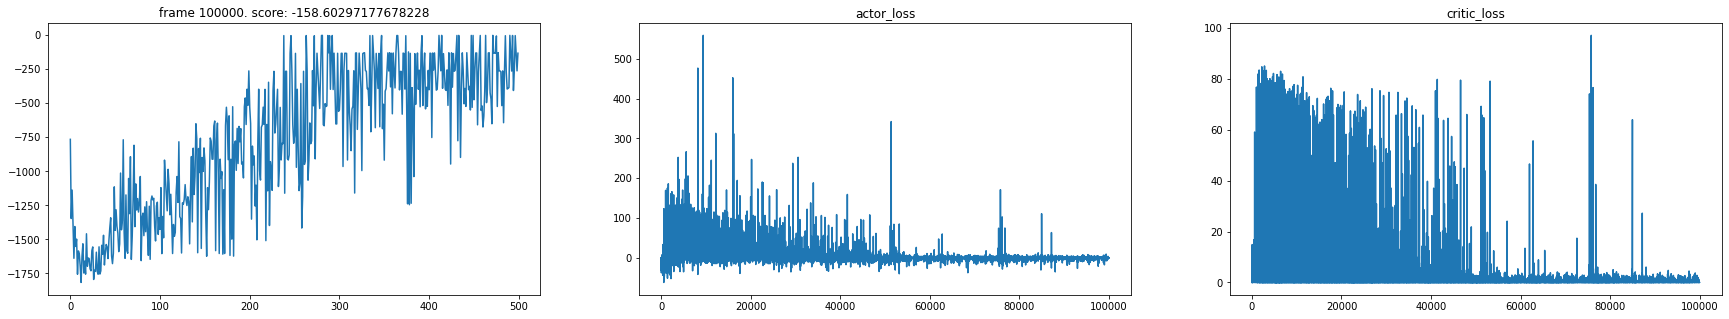

In [ ]:
agent.train(num_frames)

## Test

In [ ]:
# test
!pip install ffmpeg
!pip install imageio-ffmpeg
from gym.version import VERSION 
from gym.wrappers.record_video import RecordVideo
!pip install pygame
print(VERSION) 
# agent.env = gym.wrappers.Monitor(agent.env.render(), "videos", force=True)
agent.env = RecordVideo(agent.env, "videos")
frames = agent.test()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 6.8 MB/s 
0.25.2


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be rem

score:  -263.48563183026147


## Render

In [ ]:
# for colab
import base64
import glob
import io
import os
from IPython.display import HTML, display

def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
      data="""
      <video alt="test" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
      </video>
      """.format(encoded.decode("ascii"))
    ))

list_of_files = glob.glob("videos/*.mp4")
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
ipython_show_video(latest_file)

videos/rl-video-episode-0.mp4
